In [17]:
from __future__ import absolute_import, division, print_function

import sys
import os
import time
import pickle

sys.path.insert(0,'../../')
sys.path.insert(0,'../../../py')

import parameters
import utilities
from spectrogram_utilities import spectrogram_plot, spectrogram_hist, spectrogram_pred
import output_utilities
import spectrogram_output_visualiser
from spectrogram_cuts_db_creation import load_spectrogram_cuts_h5py

import numpy as np
import pandas as pd
import h5py

import tensorflow as tf

from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier



from scipy import signal
from sklearn import preprocessing, metrics
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# matplotlib.get_backend()
%matplotlib inline

# constants
awd_event = 1
site = parameters.sites[0]

# use gpu
from keras import backend as K
print('GPUs:',K.tensorflow_backend._get_available_gpus())
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))


GPUs: ['/job:localhost/replica:0/task:0/device:GPU:0']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## Database

### Loading H5 files

In [18]:
# load dataset from every site
# training_set_1 = 'training_set_'+site+'.h5'
# training_set_2 = 'training_set_'+site+'_augmented.h5'

# data, pb, evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, training_set_1 , verbose=True, noise=True)
# _data, pb, _evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, training_set_2 , verbose=True, noise=True)

# data = np.append(data, _data, axis=0)
# evt = np.append(evt, _evt, axis=0)

# _data =0
# _evt = 0
_data, _evt = load_spectrogram_cuts_h5py(awd_event, site, verbose=True)


Loading spectrogram cuts from training database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 20.04 seconds


In [19]:
data = np.copy(_data)
evt = np.copy(_evt)
print(data.shape, evt.shape)

# suffle data
data = list(zip(data,evt))
np.random.seed(7)
np.random.shuffle(data)
np.random.seed(23)
np.random.shuffle(data)
data, evt = zip(*data)
data = np.array(data)
evt = np.array(evt)

data = data.reshape(len(data), parameters.clf_input_width*parameters.clf_input_height)
print(data.shape, evt.shape)

_data = np.copy(data)
_evt = np.copy(evt)


# scale data
scaler = preprocessing.StandardScaler().fit(data)
# save scaler
standard_scaler = {"scaler": scaler}
pickle.dump( standard_scaler, open( 'scaler.pickle', "wb" ) )
# scale data
data = scaler.transform(data)

# reshape for CNN
data = data.reshape((len(data),parameters.clf_input_depth,
              parameters.clf_input_width,
              parameters.clf_input_height))
evt = np_utils.to_categorical(evt)

print(data.shape, evt.shape)

(18712, 128, 128) (18712,)
(18712, 16384) (18712,)
(18712, 1, 128, 128) (18712, 2)


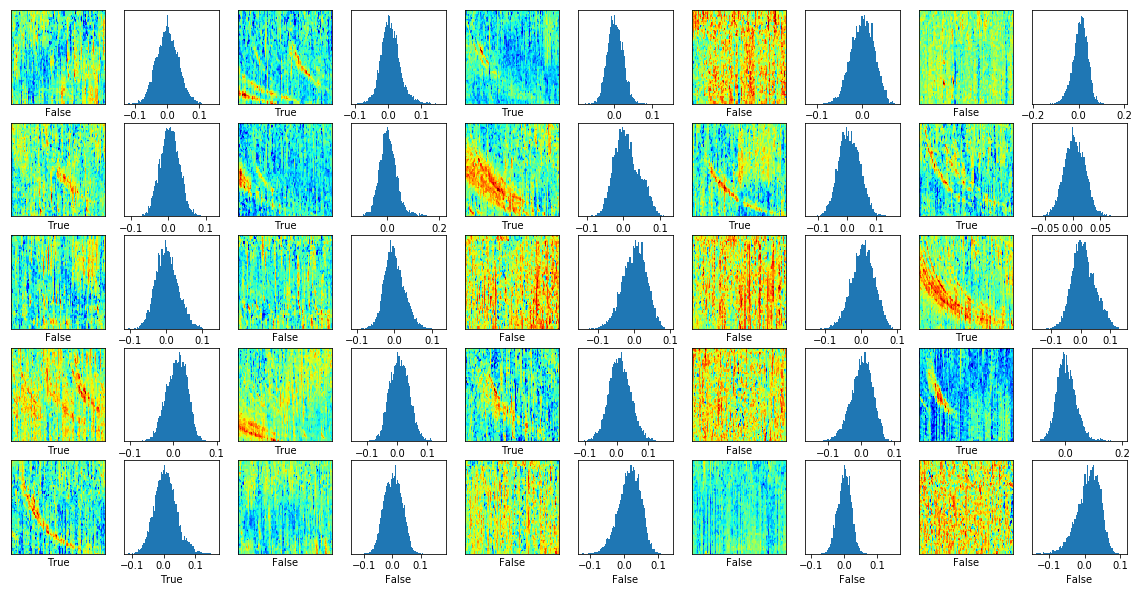

In [20]:
_data = _data.reshape((len(_data),parameters.clf_input_depth,
              parameters.clf_input_width,
              parameters.clf_input_height))
_evt = np_utils.to_categorical(_evt)
plt.figure(figsize=(10*2,10))
for i in range(0,25*2,2):
    k = np.random.randint(len(_data))
    plt.subplot(5,5*2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.pcolormesh(_data[k][0], cmap='jet')
    plt.xlabel(np.bool_(evt[k][1]))    
    plt.subplot(5,5*2,i+2)
    plt.yticks([])
    plt.grid(False)
    plt.hist(_data[k][0].flatten(), bins='auto')
    plt.xlabel(np.bool_(evt[k][1]))
#     spectrogram_plot(data[k][0])
plt.show()


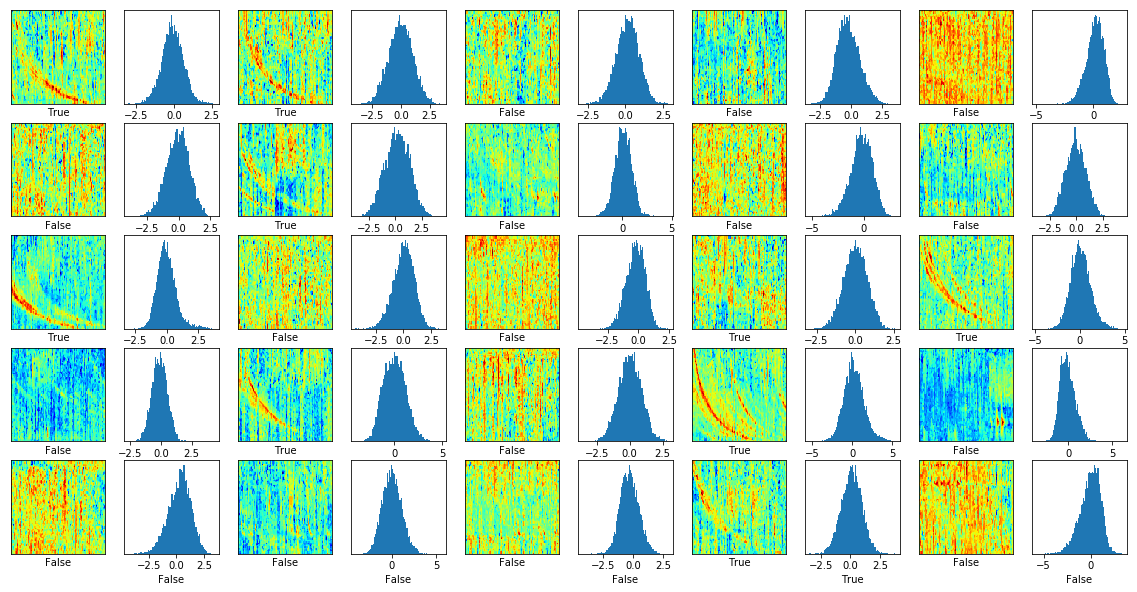

In [21]:
plt.figure(figsize=(10*2,10))
for i in range(0,25*2,2):
    k = np.random.randint(len(data))
    plt.subplot(5,5*2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.pcolormesh(data[k][0], cmap='jet')
    plt.xlabel(np.bool_(evt[k][1]))    
    plt.subplot(5,5*2,i+2)
    plt.yticks([])
    plt.grid(False)
    plt.hist(data[k][0].flatten(), bins='auto')
    plt.xlabel(np.bool_(evt[k][1]))
#     spectrogram_plot(data[k][0])
plt.show()


In [25]:
def create_model():
    # create the model
    model = Sequential()
    model.add(Conv2D(32,(3,3), input_shape=(parameters.clf_input_depth,parameters.clf_input_width, parameters.clf_input_height),
                    padding='same', activation='relu',data_format='channels_first'))
    model.add(Dropout(0.7))
    model.add(Conv2D(16, (3,3), activation='relu', padding='same',data_format='channels_first'))
    model.add(Dropout(0.8))
    model.add(Conv2D(8, (3,3), activation='relu', padding='same',data_format='channels_first'))
    model.add(MaxPooling2D(pool_size=(2,2),data_format='channels_first'))
#     model.add(Conv2D(16, (3,3), activation='relu', padding='same',data_format='channels_first'))
#     model.add(Conv2D(4, (3,3), activation='relu', padding='same',data_format='channels_first'))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.9))
    model.add(Dense(2, activation='softmax'))

    # compile model
    epochs = 25
    lrate = 0.01
    decay = lrate/epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    adam = Adam(lr=lrate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    print(model.summary())
    return model
# model = KerasClassifier(build_fn=createhttps://readms.net/_model)
model = create_model()

model.save('cnn.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 128, 128)      320       
_________________________________________________________________
dropout_19 (Dropout)         (None, 32, 128, 128)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 16, 128, 128)      4624      
_________________________________________________________________
dropout_20 (Dropout)         (None, 16, 128, 128)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 8, 128, 128)       1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 64, 64)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)             0         
__________

Train on 14969 samples, validate on 3743 samples
Epoch 1/10
14969/14969 [==============================] - 23s 2ms/step - loss: 0.5974 - acc: 0.8035 - val_loss: 0.8167 - val_acc: 0.6190
Epoch 2/10
14969/14969 [==============================] - 23s 2ms/step - loss: 0.1704 - acc: 0.9452 - val_loss: 0.1923 - val_acc: 0.9180
Epoch 3/10
14969/14969 [==============================] - 23s 2ms/step - loss: 0.1108 - acc: 0.9653 - val_loss: 0.1230 - val_acc: 0.9530
Epoch 4/10
14969/14969 [==============================] - 23s 2ms/step - loss: 0.0895 - acc: 0.9717 - val_loss: 0.1153 - val_acc: 0.9532
Epoch 5/10
14969/14969 [==============================] - 23s 2ms/step - loss: 0.0730 - acc: 0.9769 - val_loss: 0.1469 - val_acc: 0.9380
Epoch 6/10
14969/14969 [==============================] - 23s 2ms/step - loss: 0.0666 - acc: 0.9788 - val_loss: 0.0996 - val_acc: 0.9607
Epoch 7/10
14969/14969 [==============================] - 23s 2ms/step - loss: 0.0581 - acc: 0.9816 - val_loss: 0.1012 - val_acc:

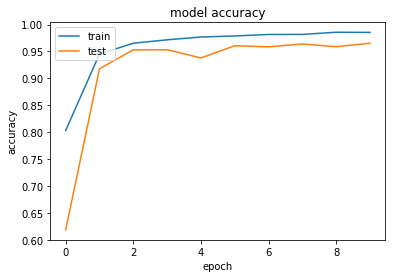

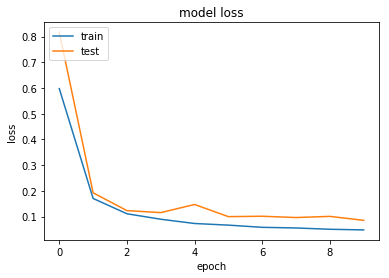

In [26]:
history = model.fit(data, evt, validation_split=0.2, epochs=10, batch_size=100)

print(history.history.keys())
# summarize history for accuracy
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [27]:
_history = model.fit(data, evt, validation_split=0.2, epochs=1, batch_size=100)

print(history.history['loss'][-1], history.history['val_loss'][-1])
print(_history.history['loss'], _history.history['val_loss'])

Train on 14969 samples, validate on 3743 samples
Epoch 1/1
14969/14969 [==============================] - 23s 2ms/step - loss: 0.0449 - acc: 0.9858 - val_loss: 0.0688 - val_acc: 0.9727
0.0479894539047543 0.08519142805025152
[0.04489356304813599] [0.06875312529681457]


In [31]:
# load dataset from every site
# testing_set_1 = 'testing_set_'+site+'.h5'
# testing_set_2 = 'testing_set_'+site+'_augmented.h5'

# data, pb, evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, testing_set_1 , verbose=True, noise=True)
# _data, pb, _evt, f_cut_length, t_cut_length = spectrogram_cuts_db_creation.load_spectrogram_cuts_db(awd_event, site, testing_set_2 , verbose=True, noise=True)

# data = np.append(data, _data, axis=0)
# evt = np.append(evt, _evt, axis=0)

# _data =0
# _evt = 0

_data, _evt = load_spectrogram_cuts_h5py(awd_event, site, verbose=True, partition='testing')
_data = _data.reshape(len(_data), parameters.clf_input_width*parameters.clf_input_height)
_data = scaler.transform(_data)

_data = _data.reshape((len(_data),parameters.clf_input_depth,
              parameters.clf_input_width,
              parameters.clf_input_height))

_evt = np_utils.to_categorical(_evt)

pred = model.predict(_data, batch_size=50)
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(_evt.argmax(axis=-1), pred.argmax(axis=-1))))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(_evt.argmax(axis=-1), pred.argmax(axis=-1)))


Loading spectrogram cuts from testing database for awdEvent1/marion
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........
Runtime: 10.10 seconds
Classification report for classifier <keras.engine.sequential.Sequential object at 0x7f26f0579e10>:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5778
           1       0.39      1.00      0.56      3695

    accuracy                           0.39      9473
   macro avg       0.20      0.50      0.28      9473
weighted avg       0.15      0.39      0.22      9473


Confusion matrix:
[[   0 5778]
 [   0 3695]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


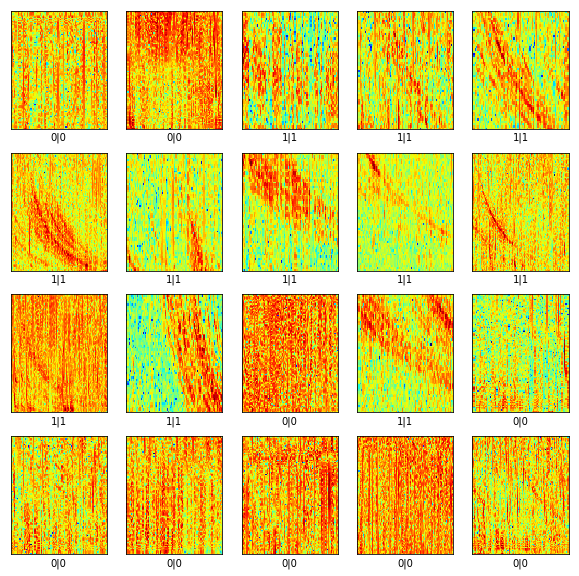

In [10]:
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(4,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    k = np.random.randint(len(data))
    plt.pcolormesh(data[k][0], cmap='jet')
    plt.xlabel(str(pred[k].argmax(axis=-1))+'|'+str(evt[k].argmax(axis=-1)))
plt.show()
# pred = np.argmax(predictions, axis=1)

# print("Classification report for classifier %s:\n%s\n"
#       % (model, metrics.classification_report(evt, pred)))
# print("Confusion matrix:\n%s" % metrics.confusion_matrix(evt, pred))

In [13]:
print(pred[:10])
print(evt[:10])

[0 0 0 0 0 0 0 0 0 0]
[ True  True False False False  True  True  True  True False]
